In [1]:
# data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as po
import plotly.graph_objs as go

# run external scripts
import matlab.engine as mateng
import os
from shutil import copyfile
import argparse
from tqdm import tqdm_notebook
import cv2

import time
from multiprocessing import Pool

#### Start an instance of MATLAB on the background

**Note**: 
- Can only get output from a function, in that case set `nargout` to the number of expected output arguments. Parse args like so: `t = eng.gcd(100.0,80.0,nargout=3)`
- Else set `nargout` to 0. In this case, any output will be displayed on terminal.

In [6]:
MAX_NUM_CORES_TO_USE = int(os.cpu_count()/2)
print(MAX_NUM_CORES_TO_USE, 'AND', 4//MAX_NUM_CORES_TO_USE)

6 AND 0


In [ ]:
# test matlab.engine
eng = mateng.start_matlab()
eng.test_script(nargout=0)   # run maketissue.m 
eng.quit()

In [ ]:
eng = mateng.start_matlab()

for i in range(len(tissuelist)):
    #tissue = tissuelist[i]
    #cmd = './mcxyz ' + tissue 
    eng.test_script(nargout=0)   # run maketissue.m 
    #print('error code:', d, '...no errors!')
    #if d != 0:
        #print('error code:', d, '...exiting computation')
        #break
eng.quit()

In [24]:
# tissue_vox = np.genfromtxt('skinvessel-500_T.bin')
with open("skinvessel-500_T.bin", "rb") as binary_file:
    # Read the whole file at once
    data = binary_file.read()
    print(type(data))

<class 'bytes'>


In [75]:
dt = np.ubyte 
data = np.fromfile(b"skinvessel-500_T.bin", dtype=dt)
print(type(data), ', data shape: ', data.shape)

df = pd.DataFrame(data, columns=data.dtype.names)
df.sample(3) #df.head(7)

<class 'numpy.ndarray'> , data shape:  (8000000,)


,0
3285391,4
1322556,4
1935390,4


In [41]:
nbins = 200
tissue_vox = data.reshape(nbins, nbins, nbins)
print('Shape after reshaping: ', tissue_vox.shape)

Shape after reshaping:  (200, 200, 200)


(200, 200)


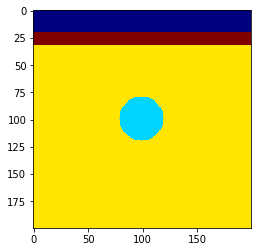

In [76]:
xs = tissue_vox[:,:,190]
print(xs.shape)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(xs, cmap='jet')

In [60]:
xs = tissue_vox[:,1,1]
print(xs.shape)

(200,)


In [64]:
z_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')
print(z_data.shape)

(25, 25)


#### Run `mcxyz` from system 

Watch out for exit code 0 and progress accordingly. If the error code is 0, that usually means that the process exited without errors.

In [11]:
tissue = 'skinvessel-500'
cmd = './mcxyz ' + tissue
print(type(cmd))

<class 'str'>


In [12]:
d = os.system(cmd)
print('error code:', d, '...exiting computation!')

error code: 2 ...exiting computation!


In [4]:
# system call to mcxyz

for i in range(len(tissuelist)):
    tissue = tissuelist[i]
    cmd = './mcxyz ' + tissue # command to parse to os.system
    d = os.system(cmd) # d = os.system('./mcxyz skinvessel-500')
    print('error code:', d, '...no errors!')
    if d != 0:
        print('error code:', d, '...exiting computation')
        break


2

In [66]:
wave = pd.read_csv('wave.csv')
for i in range(len(wave)):
    print(float(wave['nm'][i]), 'test_tissue_'+str(wave['nm'][i]))

530.0 test_tissue_530
531.0 test_tissue_531
532.0 test_tissue_532
533.0 test_tissue_533
534.0 test_tissue_534
535.0 test_tissue_535
536.0 test_tissue_536
537.0 test_tissue_537
538.0 test_tissue_538
539.0 test_tissue_539
540.0 test_tissue_540


In [72]:
#tissueName = 'test_tissue_'+str(wave['nm'][i])+'_T.bin'
tissueName = 'skinvessel_'+str(wave['nm'][i])
print(tissueName)

skinvessel_540


In [73]:
dt = np.ubyte 
data = np.fromfile(tissueName+'_T.bin', dtype=dt)
print(type(data), ', data shape: ', data.shape)

<class 'numpy.ndarray'> , data shape:  (8000000,)


In [86]:
print(np.cbrt(data.shape[0]))

200.0


In [84]:
#from tqdm import tqdm_notebook
nm = 530
eng = mateng.start_matlab()

for i in range(10):
    nm += i
    tissueName = 'test_tissue_'+str(nm)
    lk = eng.lookfluence(float(nm), tissueName, nargout=1)

    if lk == 1:
        print('Tissue structure successfully visualized!')
    else:
        print('Possible error, check look.m code in MATLAB!')

eng.quit()

Tissue structure successfully visualized!


#### Converting output fluence maps per wavelength to movie

In [8]:
#wave = pd.read_csv('wave2.csv')
img=[]

for i in range(len(wave)):
    tissueName = 'tissue_'+str(wave['nm'][i])+'_Fzx.jpg' # '_Fzy.jpg'
    print(tissueName)
    img.append(cv2.imread(tissueName))

height,width,layers=img[1].shape

video=cv2.VideoWriter('fluence.mp4',-1,1,(width,height))

for j in range(0,2):
    video.write(img[j])

cv2.destroyAllWindows()
video.release()

tissue_530_Fzx.jpg
tissue_531_Fzx.jpg
875 1167 3


In [ ]:
wave = pd.read_csv('wave2.csv')

for i in tqdm(range(len(wave))):
    tissueName = 'test_tiss_'+str(wave['nm'][i])
    cmd = './mcxyz ' + tissueName
    d = os.system(cmd)
    print('Error Code:', d, '...No errors!')
    if d != 0:
        print('Error Code:', d, '...exiting computation')
        break 

In [66]:
NUM_PROC = 6 # NUM OF PROCESSES
LEN_WAVE = 36 # LENGTH OF WAVE >> NUMBER OF WAVELENGTH VARIABLES

print(f'approximate total simulation time: {np.ceil(LEN_WAVE/NUM_PROC) * 10} minutes, {np.ceil(LEN_WAVE/NUM_PROC) * 10 / 60} hours.')
for i in range(0, LEN_WAVE, NUM_PROC):
    #print('running simulation batch: ', int((i+NUM_PROC)/NUM_PROC))
    if i+NUM_PROC < LEN_WAVE:
        rng = range(i, i+NUM_PROC)
    elif LEN_WAVE-i <= NUM_PROC:
        rng = range(i, LEN_WAVE)
        
    print('running simulation batch >> ', int((i+NUM_PROC)/NUM_PROC), ', for wavelengths @ ', list(rng))

print("---------------- END -----------------")

approximate total simulation time: 60.0 minutes, 1.0 hours.
running simulation batch >>  1 for wavelengths @  [0, 1, 2, 3, 4, 5]
running simulation batch >>  2 for wavelengths @  [6, 7, 8, 9, 10, 11]
running simulation batch >>  3 for wavelengths @  [12, 13, 14, 15, 16, 17]
running simulation batch >>  4 for wavelengths @  [18, 19, 20, 21, 22, 23]
running simulation batch >>  5 for wavelengths @  [24, 25, 26, 27, 28, 29]
running simulation batch >>  6 for wavelengths @  [30, 31, 32, 33, 34, 35]
-------- END ---------


In [61]:
print(np.ceil(LEN_WAVE/NUM_PROC))

44.0
